# Supervised text classification
Examples from [https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus](https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus)

In [12]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [13]:
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv('/Users/flint/Data/blogtext/blogtext.csv')

In [15]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [16]:
print(data.loc[0].text)

           Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait untill our team leader has processed it and learns html.         


## Create some age classes

In [17]:
agek = []
for a in data.age.values:
    if a < 20:
        agek.append("< 20")
    elif a < 30:
        agek.append("20-30")
    else:
        agek.append("> 30")
data['agek'] = agek

In [18]:
data.head()

,id,gender,age,topic,sign,date,text,agek
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",< 20
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,< 20
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,< 20
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,< 20
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,> 30


## Get a dataset sample and show some stats

In [19]:
sample = data.sample(frac=0.01)
sample.shape

(6813, 8)

In [20]:
def get_hist(var):
    g = list(sample.groupby(var).count()['id'].items())
    return [x for x, y in g], [y for x, y in g]

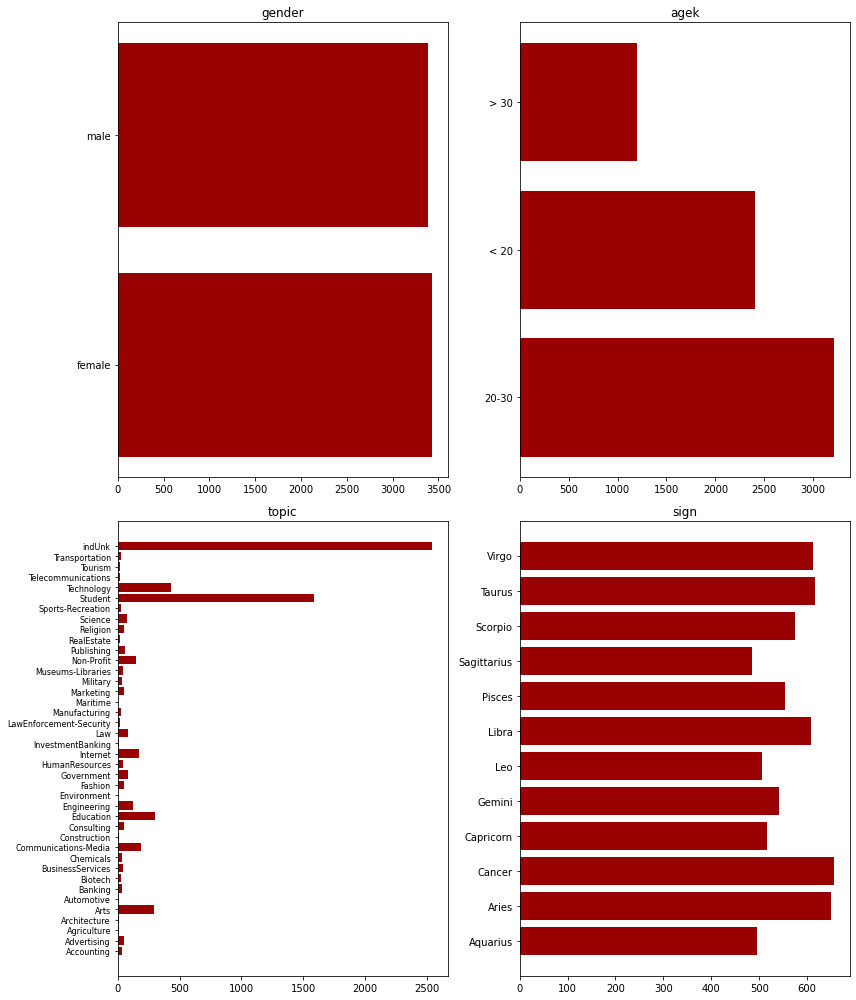

In [21]:
variables = ['gender', 'agek', 'topic', 'sign']
fig, ax = plt.subplots(figsize=(12, 14), ncols=2, nrows=2)
for i, v in enumerate(variables):
    ix, iy = i // 2, i % 2
    x, y = get_hist(v)
    ax[ix, iy].barh(x, y, color='#990000')
    ax[ix, iy].set_title(v)
    if v == 'topic':
        ax[ix, iy].tick_params(axis='y', which='major', labelsize=8)
plt.tight_layout()
plt.show()

## Convert categorical information into vectors

### One-hot encoding vs numerical encoding

In [22]:
from sklearn import preprocessing

In [23]:
le = preprocessing.LabelEncoder()
le.fit(sample.sign.unique())
y_sign = le.transform(sample.sign.values)

In [24]:
le.classes_

array(['Aquarius', 'Aries', 'Cancer', 'Capricorn', 'Gemini', 'Leo',
       'Libra', 'Pisces', 'Sagittarius', 'Scorpio', 'Taurus', 'Virgo'],
      dtype=object)

In [25]:
print(y_sign[:8], [le.classes_[x] for x in y_sign[:8]])

[ 4  2  9 11  8  6  3  3] ['Gemini', 'Cancer', 'Scorpio', 'Virgo', 'Sagittarius', 'Libra', 'Capricorn', 'Capricorn']


In [26]:
oe = preprocessing.OneHotEncoder()
oe.fit(sample.sign.unique().reshape(-1, 1))
y_sign = oe.transform(sample.sign.values.reshape(-1, 1))

In [27]:
oe.get_feature_names_out()

array(['x0_Aquarius', 'x0_Aries', 'x0_Cancer', 'x0_Capricorn',
       'x0_Gemini', 'x0_Leo', 'x0_Libra', 'x0_Pisces', 'x0_Sagittarius',
       'x0_Scorpio', 'x0_Taurus', 'x0_Virgo'], dtype=object)

In [28]:
y_sign.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Encoding text
- Tokenizers
- Pre-processing
- Vectorization

In [29]:
from nltk import word_tokenize

In [30]:
docs = [word_tokenize(x.lower()) for x in sample.text.values]

In [31]:
print(docs[0][:20])

['as', 'i', 'do', 'every', 'morning', ',', 'i', 'went', 'to', 'urllink', 'ajc.com', 'this', 'morning', 'to', 'read', 'the', 'news', 'and', 'i', 'came']


In [41]:
" ".join(docs[0])

"as i do every morning , i went to urllink ajc.com this morning to read the news and i came across this urllink article on bill cosby . he is totally going off . at first i was somewhat offended but ... he 's making a whole lot of damn sense . a lot ! ! ! bill cosby is someone who is highly respected inthe black community and i think that we should all take heed to what he is saying . there are so many kids that i come across that can not talk . and even more ... there are so many freakin ' adults that ca n't even speak correctly . i remember some of my fellow students in college that still had fucked up grammar . or they can actually speak correctly , but they ca n't fuckin ' write ! now ... before i start receiving hate mail ... let me say that in my environment , i do come across more intelligent blacks . blacks with degrees and those without that do not fall into this disenfrachised category in which bill speaks of . but , there are still so many of us that just ca n't get it right

### Indexing

In [32]:
from collections import defaultdict, Counter

In [33]:
I = defaultdict(lambda: defaultdict(lambda: 0))
W = defaultdict(lambda: 0)
run = tqdm(list(enumerate(docs)))
for i, doc in run:
    wordtf = Counter(doc).most_common()
    for word, tf in wordtf:
        W[word] += 1
        I[i][word] += tf

  0%|          | 0/6813 [00:00<?, ?it/s]

In [34]:
W['love'], I[0]['home']

(986, 0)

In [35]:
vocabulary = list(W.keys())
vindex = dict([(w, i) for i, w in enumerate(vocabulary)])
X = np.zeros((len(docs), len(vocabulary)))
for idoc, words in I.items():
    for w, tf in words.items():
        X[idoc, vindex[w]] = tf
Xf = pd.DataFrame(X, columns=vocabulary)

In [38]:
Xf.shape

(6813, 64245)

In [39]:
Xf

,.,i,that,and,",",...,do,is,but,it,...,domestic-church.com,lolishness,decidin,grouchyishness,laterishness,sillyish,explaininishness,worldishness,subjunctive,excercises
0,15.0,12.0,9.0,8.0,7.0,6.0,5.0,5.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,6.0,0.0,2.0,4.0,6.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.0,15.0,1.0,4.0,15.0,1.0,0.0,4.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6808,5.0,21.0,10.0,6.0,0.0,25.0,7.0,13.0,4.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6809,0.0,10.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6810,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6811,0.0,0.0,1.0,1.0,0.0,4.0,2.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [42]:
Xf.loc[0].sort_values(ascending=False)

.             15.0
i             12.0
that           9.0
and            8.0
,              7.0
              ... 
wearer         0.0
silhouette     0.0
pennies        0.0
medecines      0.0
excercises     0.0
Name: 0, Length: 64245, dtype: float64

In [47]:
(Xf['mother'] > 0).sum()

150

In [48]:
idf = dict([(w, np.log(len(docs) / W[w])) for w in vocabulary])

In [49]:
idf['and'], idf['mother']

(0.32227726518844435, 3.8159525366774125)

In [50]:
Xf.loc[0].sort_values(ascending=False)[:10]

.       15.0
i       12.0
that     9.0
and      8.0
,        7.0
...      6.0
do       5.0
is       5.0
but      5.0
it       5.0
Name: 0, dtype: float64

In [51]:
IDF = pd.Series(idf)
Xidf = Xf * IDF

In [52]:
Xidf.loc[0].sort_values(ascending=False)[:10]

cosby             20.642033
bill              16.326623
blacks            14.069657
grammar           12.683362
offended          11.764298
across            11.254242
correctly         11.061502
ajc.com            8.826588
disenfrachised     8.826588
inthe              8.826588
Name: 0, dtype: float64

## Build a classifier

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
import torch

In [ ]:
vocab = build_vocab_from_iterator(docs, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab(['here', 'is', 'an', 'example'])

In [ ]:
text_pipeline = lambda x: vocab(x)
label_pipeline = lambda x: int(x)

In [ ]:
text_pipeline(docs[0])[:4]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

## Get train dataset for age classification

In [ ]:
from torch import nn

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(sample.agek.unique())
y_agek = le.transform(sample.agek.values)

In [ ]:
labels = list(enumerate(y_agek))
np.random.shuffle(labels)
limit = int(len(labels) * .8)
y_train, y_test = labels[:limit], labels[limit:]
train_dataset = [(lab, docs[i]) for i, lab in y_train]
test_dataset = [(lab, docs[i]) for i, lab in y_test]

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

We build a model with the embedding dimension of 64. The vocab size is equal to the length of the vocabulary instance. The number of classes is equal to the number of labels,

In [ ]:
num_class = len(le.classes_)
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

### Training

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

### Run training

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset


EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

total_accu = None

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(test_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

## Comparing train and test predictions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
y_train = []
train_pred = []
for idx, (label, text, offsets) in enumerate(train_dataloader):
    predicted_label = model(text, offsets).argmax(dim=1)
    for i, l in enumerate(label):
        y_train.append(int(l))
        train_pred.append(int(predicted_label[i]))
y_test = []
test_pred = []
for idx, (label, text, offsets) in enumerate(test_dataloader):
    predicted_label = model(text, offsets).argmax(dim=1)
    for i, l in enumerate(label):
        y_test.append(int(l))
        test_pred.append(int(predicted_label[i]))

In [ ]:
print(classification_report(y_train, train_pred))

In [ ]:
print(classification_report(y_test, test_pred))

In [ ]:
cm1, cm2 = confusion_matrix(y_train, train_pred), confusion_matrix(y_test, test_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=le.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=le.classes_)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7), ncols=2, nrows=1)
disp1.plot(ax=ax[0])
disp2.plot(ax=ax[1])
plt.tight_layout()
plt.show()